# Загрузка данных

In [1]:
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from concurrent.futures import ThreadPoolExecutor
import pickle
import shutil
from shutil import copyfile
import torchvision
from torchvision import models, datasets, transforms
import torch
from torchsummary import summary
from collections import Counter
import sys

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# Путь к папке с данными
path_train = '/content/drive/MyDrive/Test/MA/data'

In [4]:
# Оценим соотношение
train_data = pd.read_csv(path_train + '/train.csv')
val_data = pd.read_csv(path_train + '/val.csv')
test_data = pd.read_csv(path_train + '/test.csv')
print('Train data \n', train_data.head(5))
print(train_data.count())
print('Уникальных значений в train', train_data['text'].nunique())
print(' ')
print('Val data \n',val_data.head(5))
print('Уникальных значений в val', val_data['text'].nunique())
print(val_data.count())
print(' ')
print('Test data \n',test_data.head(5))
print(test_data.count())
print(' ')

# Содержится ли множество цифр val в train
interception_features = (set(train_data['text'])) & set(val_data['text'])  # не все признаки, что есть в val, есть в test, а лишь 205/218
print(len(interception_features))
missing_in_train = set(val_data['text']) - set(train_data['text'])
print(len(missing_in_train))

Train data 
           img_name   text
0  511192609_2.jpg  109.0
1  508986495_2.jpg   64.0
2  511284449_2.jpg  101.0
3  509225880_2.jpg  229.0
4  509069568_2.jpg   39.0
img_name    4952
text        4952
dtype: int64
Уникальных значений в train 296
 
Val data 
           img_name   text
0  508763287_2.jpg  105.0
1  508811724_2.jpg   33.0
2  508757581_2.jpg   23.0
3  509323355_2.jpg   79.0
4  483319419_2.jpg   95.0
Уникальных значений в val 218
img_name    1000
text        1000
dtype: int64
 
Test data 
           img_name
0  511228291_2.jpg
1  510883758_2.jpg
2  509390607_2.jpg
3  508764417_2.jpg
4  510880074_2.jpg
img_name    238
dtype: int64
 
205
13


In [5]:
val_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   img_name  1000 non-null   object 
 1   text      1000 non-null   float64
dtypes: float64(1), object(1)
memory usage: 15.8+ KB


## Работа с изображениями

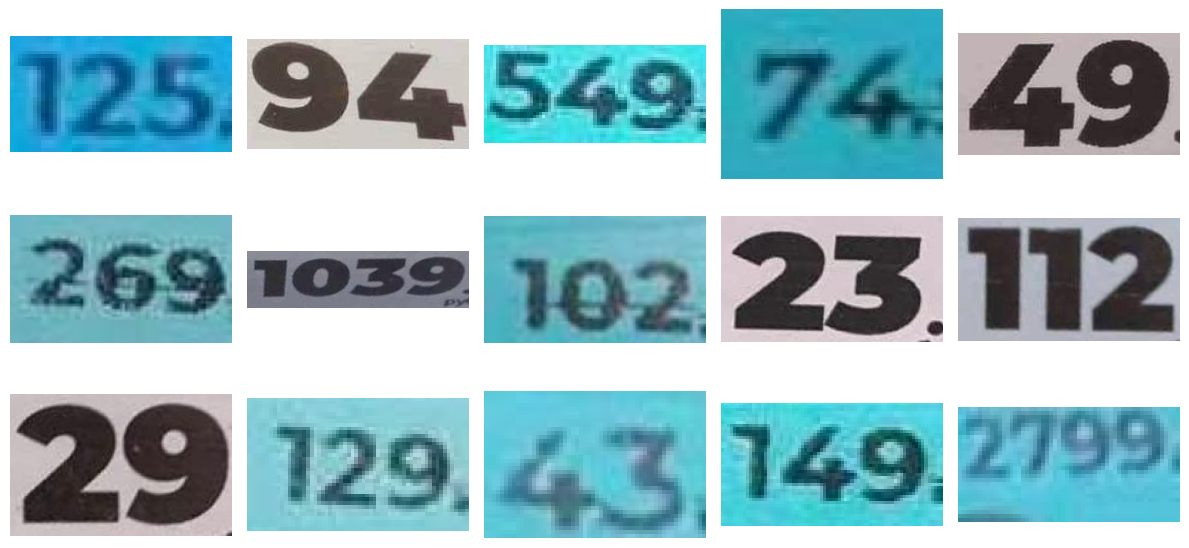

In [5]:
image_folder_path = '/content/drive/MyDrive/Test/MA/data/imgs'

fig, axes = plt.subplots(3, 5, figsize=(12, 6))

# Перебираем первые 15 файлов изображений
for i, filename in enumerate(os.listdir(image_folder_path)[:15]):
    img = Image.open(os.path.join(image_folder_path, filename))

    # Определяем позицию в сетке
    ax = axes[i // 5, i % 5]
    ax.imshow(img)
    ax.axis('off')

# Настраиваем отображение
plt.tight_layout()
plt.show()

## Сопоставление картинок из train, val, test с их номером (создание отдельных папок)

Ниже код для создания отдельных директорий для разных цифр

In [12]:
# Запустить только 1 раз

# Путь к директории с данными
# data_dir = '/content/drive/MyDrive/Test/MA/data'

# # Создание директорий для тренировки и валидации
# train_dir = os.path.join(data_dir, 'train')
# val_dir = os.path.join(data_dir, 'val')

# os.makedirs(train_dir, exist_ok=True)
# os.makedirs(val_dir, exist_ok=True)

# # Чтение CSV файлов
# train_df = pd.read_csv(os.path.join(data_dir, 'train.csv'))
# val_df = pd.read_csv(os.path.join(data_dir, 'val.csv'))

# # Перемещение изображений по классам

# def move_images(df, target_folder):
#     for index, row in df.iterrows():
#         img_name = row['img_name']
#         label_text = str(int(row['text']))  # Преобразуем текст в целое число

#         # Создание директории для класса если она не существует
#         class_folder_path = os.path.join(target_folder, label_text)
#         os.makedirs(class_folder_path, exist_ok=True)

#         # Копирование файла из исходной папки imgs в новую директорию по классу
#         src_img_path = os.path.join(data_dir,'imgs', img_name)

#         if not os.path.exists(src_img_path):
#             print(f"Файл {src_img_path} не найден.")
#             continue

#         dst_img_path = os.path.join(class_folder_path,img_name)

#         try:
#             copyfile(src_img_path,dst_img_path)
#             print(f"Копировано: {img_name} -> {dst_img_path}")

#         except Exception as e:
#             print(f"Ошибка при копировании файла: {e}")

# move_images(train_df , train_dir )
# move_images(val_df , val_dir )

Выходные данные были обрезаны до нескольких последних строк (5000).
Копировано: 508764088_2.jpg -> /content/drive/MyDrive/Test/MA/data/train/63/508764088_2.jpg
Копировано: 511270770_2.jpg -> /content/drive/MyDrive/Test/MA/data/train/169/511270770_2.jpg
Копировано: 508795803_2.jpg -> /content/drive/MyDrive/Test/MA/data/train/1099/508795803_2.jpg
Копировано: 510880864_2.jpg -> /content/drive/MyDrive/Test/MA/data/train/79/510880864_2.jpg
Копировано: 511224039_2.jpg -> /content/drive/MyDrive/Test/MA/data/train/269/511224039_2.jpg
Копировано: 510886110_2.jpg -> /content/drive/MyDrive/Test/MA/data/train/139/510886110_2.jpg
Копировано: 508811785_2.jpg -> /content/drive/MyDrive/Test/MA/data/train/139/508811785_2.jpg
Копировано: 508784492_2.jpg -> /content/drive/MyDrive/Test/MA/data/train/129/508784492_2.jpg
Копировано: 508793923_2.jpg -> /content/drive/MyDrive/Test/MA/data/train/2999/508793923_2.jpg
Копировано: 508776621_2.jpg -> /content/drive/MyDrive/Test/MA/data/train/139/508776621_2.jpg
Ко

## Создание Dataset, dataloader

In [44]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop((224,224)),
        transforms.ToTensor(),
       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop((224,224)),
        transforms.ToTensor(),
       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/Test/MA/data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=20,
                                             shuffle=True, num_workers=20)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Как выглядят изображения из 1 батча

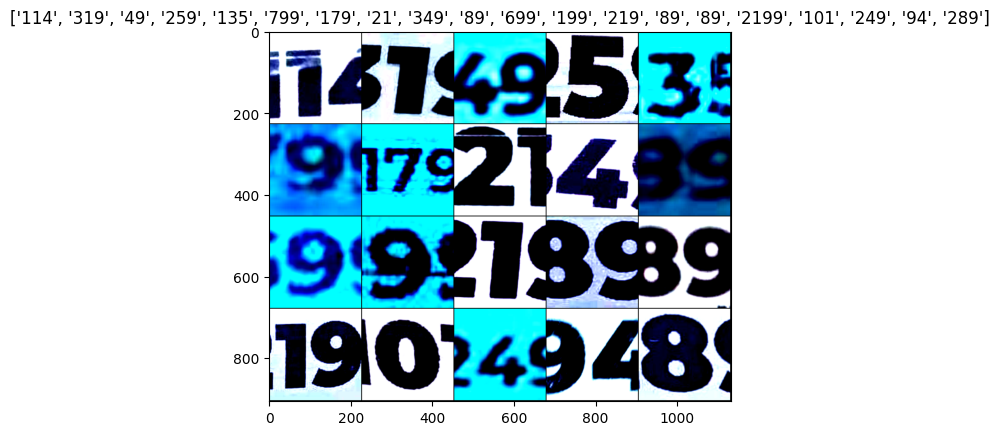

In [46]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow = 5, padding=2)

imshow(out, title=[class_names[x] for x in classes])

In [47]:
inputs.shape

torch.Size([20, 3, 224, 224])

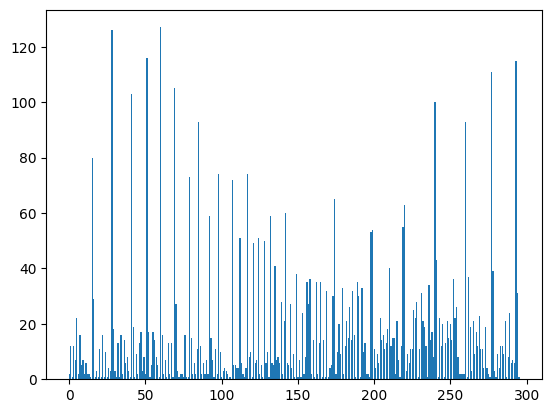

In [48]:
# Проверим баланс классов в train
oy = list(Counter(image_datasets['train'].targets).values())
ox = np.arange(len(oy))
plt.bar(ox, oy)
plt.show()

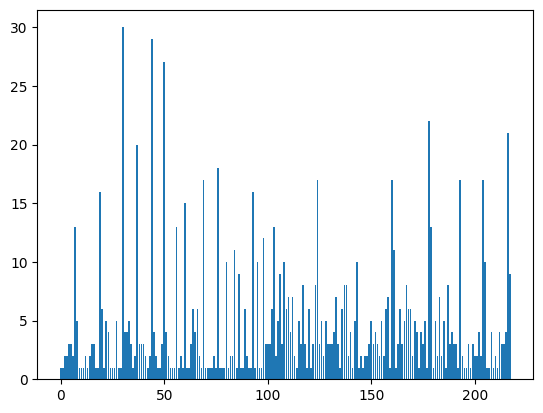

In [49]:
# Проверим баланс классов в val
oy = list(Counter(image_datasets['val'].targets).values())
ox = np.arange(len(oy))
plt.bar(ox, oy)
plt.show()

# Обучение

In [11]:
import copy
from IPython.display import clear_output
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

In [50]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch=0; best_acc = 0.0; best_loss = sys.maxsize
    hist_loss_train = []; hist_acc_train = []
    hist_loss_val = []; hist_acc_val = []

    for epoch in range(num_epochs):
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'train':
                hist_loss_train.append(epoch_loss)
                hist_acc_train.append(epoch_acc.cpu().item())
            else:
                hist_loss_val.append(epoch_loss)
                hist_acc_val.append(epoch_acc.cpu().item())
            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_acc = epoch_acc.item()
                best_loss = epoch_loss
                best_epoch = epoch
                best_model_wts = copy.deepcopy(model.state_dict())
        clear_output(True)
        plt.plot(hist_loss_train,label='hist_loss_train ({})'.format(round(hist_loss_train[-1],2)))
        plt.plot(hist_loss_val,label='hist_loss_val ({})'.format(round(hist_loss_val[-1],2)))
        plt.legend(framealpha=1, frameon=True);
        plt.title('Loss (epoch {}/{})'.format(epoch,num_epochs))
        plt.show()
    model.eval()
    plt.plot(hist_acc_train,label='hist_acc_train')
    plt.plot(hist_acc_val,label='hist_acc_val')
    plt.legend(framealpha=1, frameon=True);
    plt.title('Acc')
    plt.show()
    model.load_state_dict(best_model_wts)     # load best model weights
    return model,best_acc

In [51]:
# ls = число уникальных символов
ls = 296 # число уникальных цифр в train

In [52]:
# Загрузка предобученной модели

# model_ft = models.alexnet(pretrained=True) #  for AlexNet
model_ft = models.resnet18(pretrained=True)  #  for ResNET 18

# Замораживаем веса
for param in model_ft.parameters():
    param.requires_grad = False

# Заменяем последний слой - классификатор resnet на наш линейный слой, это единственный слой, который будет учиться
# model_ft.classifier = nn.Linear(9216, ls) #  for AlexNet
num_ftrs = model_ft.fc.in_features   #  for ResNET
model_ft.fc = nn.Linear(num_ftrs, ls)   #  for ResNET

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [53]:
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

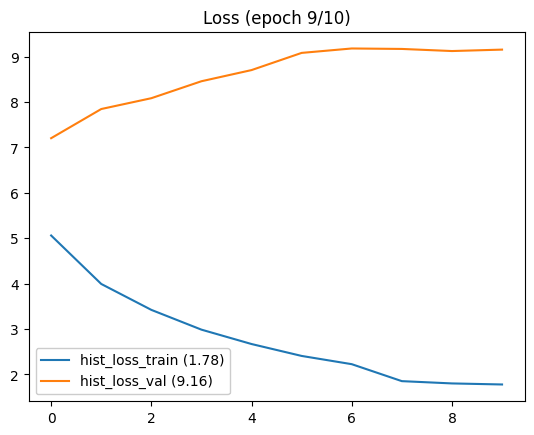

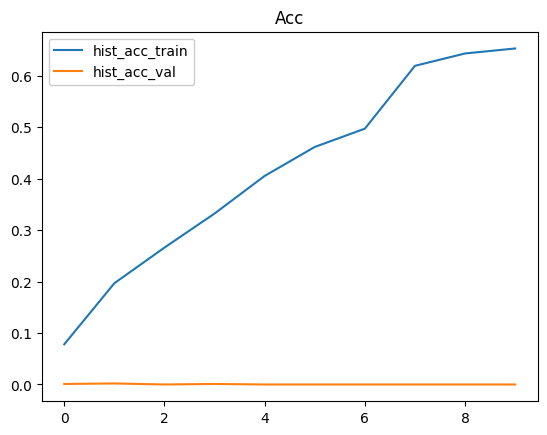

In [54]:
model_ft,best_acc = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler)

In [19]:
for param in model_ft.parameters():
    print(param.requires_grad,end=" ")  # видно, что все слои False, кроме последнего, который обучался

False False False False False False False False False False True True 

In [24]:
print("Best accuracy: {}".format(round(best_acc,3)))

Best accuracy: 0.001


Посмотрим что получилось

In [29]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

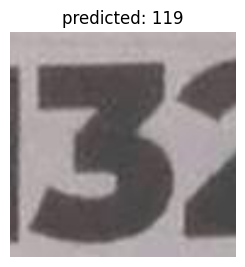

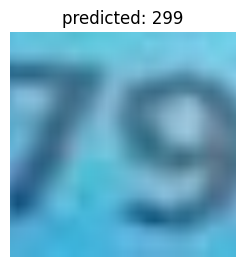

In [30]:
visualize_model(model_ft.to(device),num_images=2)

Архитектура

In [32]:
summary(model_ft,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

# ResNet18 from scratch

In [37]:
from torch import Tensor
from typing import Type

In [35]:
class BasicBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride = 1, expansion = 1, downsample = None):
        super(BasicBlock, self).__init__()
        self.expansion = expansion
        self.downsample = downsample
        self.conv1 = nn.Conv2d( in_ch, out_ch, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d( out_ch, out_ch*self.expansion, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_ch*self.expansion)
    def forward(self, x: Tensor) -> Tensor:
        identity = x
        out = self.bn2(self.conv2(self.relu(self.bn1(self.conv1(x)))))
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

In [38]:
class MyResNet(nn.Module):
    def __init__(self, img_channels=3, num_layers=18, block=Type[BasicBlock],
        num_classes  = 1000):
        super(MyResNet, self).__init__()
        if num_layers == 18:
            # The following `layers` list defines the number of `BasicBlock`
            # to use to build the network and how many basic blocks to stack
            # together.
            layers = [2, 2, 2, 2]
            self.expansion = 1
        self.in_ch = 64
        # All ResNets (18 to 152) contain a Conv2d => BN => ReLU for the first
        # three layers. Here, kernel size is 7.
        self.conv1 = nn.Conv2d(in_channels=img_channels, out_channels=self.in_ch,
            kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_ch)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512*self.expansion, num_classes)
    def _make_layer(self, block, out_ch, blocks, stride = 1):
        downsample = None
        if stride != 1:
            """
            This should pass from `layer2` to `layer4` or
            when building ResNets50 and above. Section 3.3 of the paper
            Deep Residual Learning for Image Recognition
            (https://arxiv.org/pdf/1512.03385v1.pdf).
            """
            downsample = nn.Sequential(
                nn.Conv2d(self.in_ch, out_ch*self.expansion, kernel_size=1,
                    stride=stride, bias=False),
                nn.BatchNorm2d(out_ch * self.expansion),
            )
        layers = []
        layers.append(block(self.in_ch, out_ch, stride, self.expansion, downsample))
        self.in_ch = out_ch * self.expansion
        for i in range(1, blocks):
            layers.append(block(self.in_ch, out_ch, expansion=self.expansion))
        return nn.Sequential(*layers)
    def forward(self, x: Tensor) -> Tensor:
        x = self.maxpool(self.relu(self.bn1(self.conv1(x))))
        x = self.layer4(self.layer3(self.layer2(self.layer1(x))))
        # The spatial dimension of the final layer's feature
        # map should be (7, 7) for all ResNets.
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

Создадим артефакты для обучения

In [40]:
myResNet=MyResNet(3,18, BasicBlock,ls).to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(myResNet.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Обучим собственную модель ResNet18

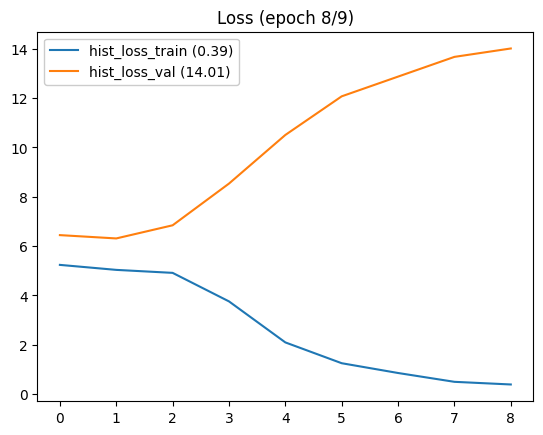

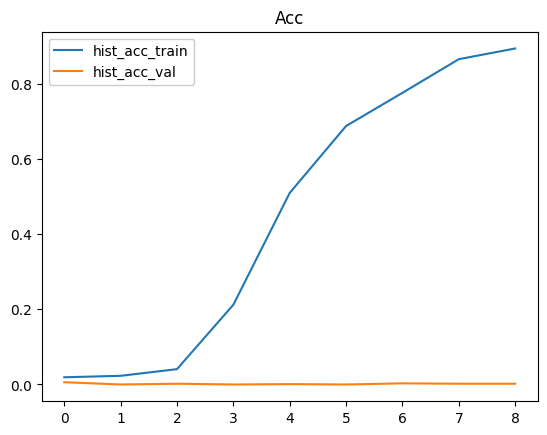

In [41]:
model_ft,best_acc = train_model(myResNet, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=9)

In [42]:
print("Best accuracy: {}".format(round(best_acc,3)))

Best accuracy: 0.0


# Выводы

Примененные CNN подходы не помогли решить задачу. Однако автор не сдается и будет исследовать подходы, совмещающие в себе CRNN и возможно трансформеры, если это не поможет.
Здесь также важно декомпозировать задачу так, чтобы в двух-, трех-, четырехзначной числе отдельно и в правильном порядке распознавались цифры, а не 2,3,4 сразу.


Спасибо за задачу! Она помогла мне развиться и стать сильнее.